In [38]:
import pandas as pd
import numpy as np

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import torch
from torch.autograd.functional import hessian
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

np.random.seed(42)

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [2]:
data = pd.read_csv('../data/winequality-red.csv')
data = (data-data.mean())/data.std()
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576


In [3]:
data.cov()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


## Linear Regression bayesian

On prends les variables 'volatile acidity', 'alcohol', 'citric acid', 'density', 'sulphates' qui vont prédire 'quality'

In [4]:
var = ['volatile acidity', 'alcohol', 'citric acid', 'density', 'sulphates']
X, y = data[var].values, data['quality'].values
D = 7

On considère $y \sim \mathcal{N}(\alpha + \beta X , \sigma^2)$, avec $\alpha, \log \sigma \sim \mathcal{N}(0, 1), \beta \sim \mathcal{N}(0, \mathbf{I})$, et $\theta=(\alpha, \beta, \log(\sigma))$

In [5]:
def get_mcmc_sample(X, y, size=5):
    prior_location = 0
    prior_scale = 1
    with pm.Model() as model:
        # Prior sur l'intercept
        alpha = pm.Normal('alpha', mu=prior_location, sigma=prior_scale)
        
        # Prior sur les coefficients de la régression linéaire
        beta = pm.Normal('beta',  mu=prior_location, sigma=prior_scale, shape=size)
        
        # Prior sur l'écart type des résultats
        log_sigma = pm.Normal('log_sigma', mu=prior_location, sigma=prior_scale)
        
        # Régression linéaire
        mu = alpha + pm.math.dot(X, beta)
        
        # Vraissemblance
        likelihood = pm.Normal('likelihood', mu=mu, sigma=np.exp(log_sigma), observed=y)
        
        # MCMC
        trace = pm.sample(2000)
    
    return trace

In [6]:
# MCMC
trace = get_mcmc_sample(X, y)

# Historique des tirages
theta = np.column_stack([trace.alpha, trace.log_sigma, trace.beta])

/var/folders/wv/2vmcq8g50l78y2b9nbkxtnw00000gn/T/ipykernel_49320/4179283471.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


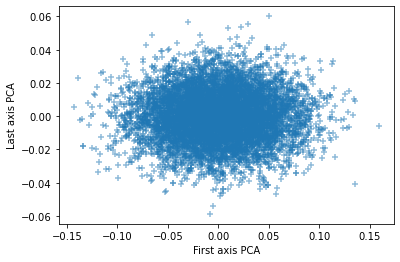

In [7]:
pca = PCA()
pca.fit(theta)
theta_pca = pca.transform(theta)
plt.scatter(theta_pca[:, 0], theta_pca[:, -1], alpha=0.5, marker='+')
plt.xlabel('First axis PCA')
plt.ylabel('Last axis PCA')
plt.show()

## Perte

On calcul les gradients suivant $\alpha, \beta, \log(\sigma)$, la loss étant:

$-\log(p(y|\theta)) + \frac{1}{N}\log(p(\theta)) = -\log(\mathcal{N}(\alpha + \beta X, e^{2*\log(\sigma)}) + \frac{1}{N}(\log(\mathcal{N}(0, 1)) + \log(\mathcal{N}(0, \mathbf{I})) + \log(\mathcal{N}(0, 1)))$ 


Avec: $p(\theta) = p(\alpha)p(\beta)p(\log \sigma)$

In [8]:
def _loss(θ, x_, y_, N):
    cst = torch.tensor(np.log(2*np.pi), requires_grad=False)
    
    # f1 correspond à l'opposé du log du postérieur
    f1 = 0.5*torch.exp(-2*θ[1]) * (θ[0] + torch.dot(θ[2:], x_)  - y_)**2 + θ[1] + 0.5*cst
    
    # f2 correspond à la "régularisation"
    f2 = (-1/(2*N))*(θ[0]**2 +  θ[1]**2 + torch.dot(θ[2:], θ[2:]) + θ.shape[0]*cst)
    
    return f1 + f2

def _loss_tot(θ, X, y):
    N = len(y)
    loss = 0
    for k in range(N):
        loss += _loss(θ, X[k], y[k], N)
    return loss / N

## SGD pas constant

In [10]:
def sgd(X, y, loss_fun, lr=1, precond=None, max_iter=1000, mini_batch_size=100):
    # Taille des données
    N=len(y)
    
    # Nombres de paramètres ie: dimension de theta
    size = X.shape[1] + 2
    
    #Initialisation de la matrice de préconditionnement si besoin
    if precond is None : precond = torch.eye(size, dtype=torch.float64) 
    
    # Historique où l'on placera les tirages
    theta_sg = torch.zeros(size=(max_iter, size), dtype=torch.float64)
    
    # Historique avec les valeurs des gradients et des loss
    val_loss = []
    
    # Initialisation du paramètre
    θ = torch.rand(size, dtype=torch.float64, requires_grad=True)
    
    for k in tqdm(range(max_iter)):
        
        # On tire un batch aléatoirement
        S = np.random.randint(N, size=mini_batch_size, dtype=int)
        
        # Calcul de la loss sur le batch de données
        loss = torch.zeros(1, dtype=torch.float64)
        for index in S:
            loss += loss_fun(θ, X[index], y[index], N)
        
        # Remise à zéros des gradients pour éviter l'accumulation
        θ.grad = None
        
        # Etape de mise à jour avec calcul des gradients
        loss.backward()
        θ.data -= lr*(precond@θ.grad) 
        
        # Ajout du paramètre tiré
        theta_sg[k] = θ.data.clone()
        
        # Ajout de la loss dans l'historique
        if k % 5 == 0:
            val_loss.append(loss.item()/mini_batch_size)
    return theta_sg, val_loss

On a $\frac{\epsilon^*}{S} = \frac{2D}{NTr(BB^T)}$, ici on a $D=4$ et on prend $BB^T=I_D$, la mise à jour de la SGD est donc:

$$ \theta(t+1) = \theta(t) - \frac{\epsilon^*}{S} \sum \limits_{i \in \mathcal{S}}-\log(p(y_i|\theta(t))) + \frac{1}{N}\log(p(\theta(t)))$$

In [23]:
X_tensor = torch.tensor(X, requires_grad=False, dtype=torch.float64) 
y_tensor = torch.tensor(y, requires_grad=False, dtype=torch.float64)

mini_batch_size = 100
B = 3*np.eye(D)
tr = np.trace(B@B.T)
lr = (2*D)/(len(y)*tr)
precond = torch.tensor((2/len(y))*np.linalg.inv(B@B.T), dtype=torch.float64, requires_grad=False)
max_iter = 4000

print('... Stochastic Gradient descent constant step')
theta_sgd_c, loss_c = sgd(X_tensor, y_tensor, _loss, lr, max_iter=max_iter, mini_batch_size=mini_batch_size)

print('... Stochastic Gradient descent preconditionning')
theta_sgd_pre, loss_pre = sgd(X_tensor, y_tensor, _loss, 1, precond, max_iter, mini_batch_size)

... Stochastic Gradient descent constant step


100%|███████████████████████████████████████| 4000/4000 [01:33<00:00, 42.64it/s]


... Stochastic Gradient descent preconditionning


100%|███████████████████████████████████████| 4000/4000 [01:32<00:00, 43.23it/s]


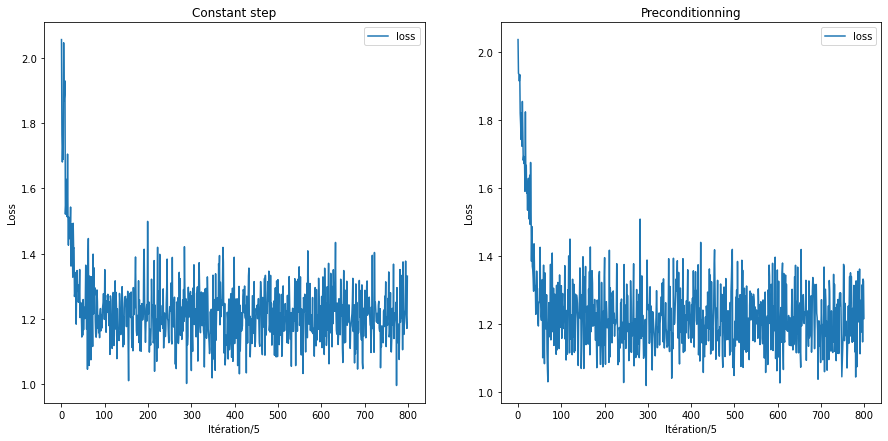

In [24]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(range(len(loss_c)), loss_c, label='loss')
plt.title('Constant step')
plt.xlabel('Itération/5')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(len(loss_pre)), loss_pre, label='loss')
plt.title('Preconditionning')
plt.xlabel('Itération/5')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

In [66]:
# On utilise le modèle de la pca déterminé précédemment dans le cadre de l'algorithme MCMC
cv_it = 100
theta_pca_sgd_c = pca.transform(theta_sgd_c[cv_it:])
theta_pca_sgd_pre = pca.transform(theta_sgd_pre[cv_it:])

Text(0.5, 1.0, 'Preconditionning')

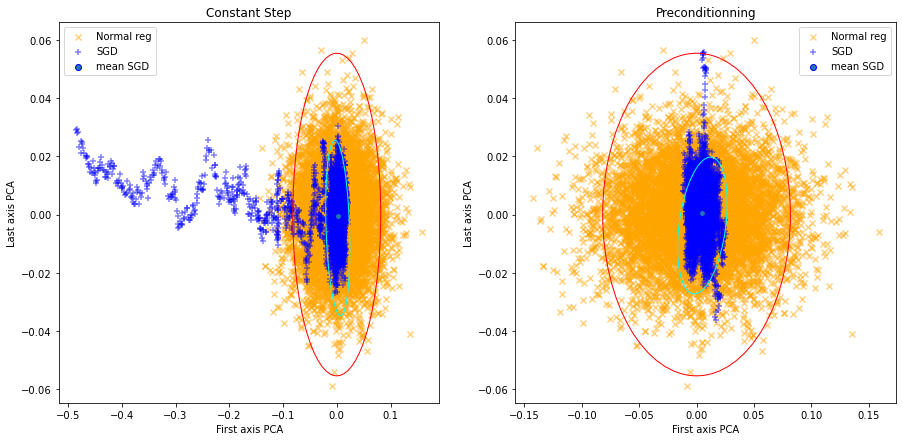

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].scatter(theta_pca[:, 0], theta_pca[:, -1], alpha=0.5, marker='x', label='Normal reg', c='orange')
axs[0].scatter(theta_pca_sgd_c[:, 0], theta_pca_sgd_c[:, -1], alpha=0.5, marker='+', label='SGD', c='blue')
axs[0].scatter(theta_pca_sgd_c[1000:, 0].mean(), theta_pca_sgd_c[1000:, -1].mean(), facecolor=None, edgecolor='blue', label='mean SGD')
confidence_ellipse(theta_pca[:, 0], theta_pca[:, 1], axs[0], n_std=2, edgecolor='red')
confidence_ellipse(theta_pca_sgd_c[1000:, 0], theta_pca_sgd_c[1000:, 1], axs[0], n_std=3, edgecolor='cyan')
axs[0].set_xlabel('First axis PCA')
axs[0].set_ylabel('Last axis PCA')
axs[0].legend(loc='best')
axs[0].set_title('Constant Step')

axs[1].scatter(theta_pca[:, 0], theta_pca[:, -1], alpha=0.5, marker='x', label='Normal reg', c='orange')
axs[1].scatter(theta_pca_sgd_pre[:, 0], theta_pca_sgd_pre[:, -1], alpha=0.5, marker='+', label='SGD', c='blue')
axs[1].scatter(theta_pca_sgd_pre[1500:, 0].mean(), theta_pca_sgd_pre[1500:, -1].mean(), facecolor=None, edgecolor='blue', label='mean SGD')
confidence_ellipse(theta_pca[:, 0], theta_pca[:, 1], axs[1], n_std=2, edgecolor='red')
confidence_ellipse(theta_pca_sgd_pre[1500:, 0], theta_pca_sgd_pre[1500:, 1], axs[1], n_std=3, edgecolor='cyan')
axs[1].set_xlabel('First axis PCA')
axs[1].set_ylabel('Last axis PCA')
axs[1].legend(loc='best')
axs[1].set_title('Preconditionning')


## Covariance TODO avec matrice B differente de l'identité

Analytiquement on a $\Sigma = -\frac{\epsilon^*}{2S} \int \limits_{0}^{\infty} e^{A\tau}d\tau =\frac{\epsilon^*}{2S}A^{-1}$ étant donné que A est symétrique inversible.
numériquement on a $\frac{lr}{2} = \frac{\epsilon^*}{2S}$

In [33]:
def lyapunov(A, B, H, eps, mini_batch_size=100):
    U, S, _ = np.linalg.svd(H@A)
    Σ = np.zeros(A.shape)
    for i in range(len(A)):
        for j in range(len(A)):
            Σ += (1/(S[i] + S[j]))*U[:,i][np.newaxis].T@U.T[i][np.newaxis]@H@B@B.T@H.T@U[:,j][np.newaxis].T@U.T[j][np.newaxis]
    return eps*Σ

In [34]:
# On détermine le theta moyen après convergence du SGD
theta_mean_c = theta_sgd_c[cv_it:].mean(axis=0).detach().clone().requires_grad_()
theta_mean_pre = theta_sgd_pre[cv_it:].mean(axis=0).detach().clone().requires_grad_()

# Loss dont on cherche la hessienne
loss = lambda θ : _loss_tot(θ, X_tensor, y_tensor)

# Calcul de la hessienne de la loss en le theta moyen
hes_c = hessian(loss, theta_mean_c).numpy()
hes_pre = hessian(loss, theta_mean_pre).numpy()

# Calcul analytique de la matrice de covariance associée à la distribution stationnaire
Σ_c = lyapunov(hes_pre, B, np.eye(len(B)), lr)#(lr/2)*np.linalg.inv(hes_c)
Σ_pre = lyapunov(hes_pre, B, precond.numpy(), 1)

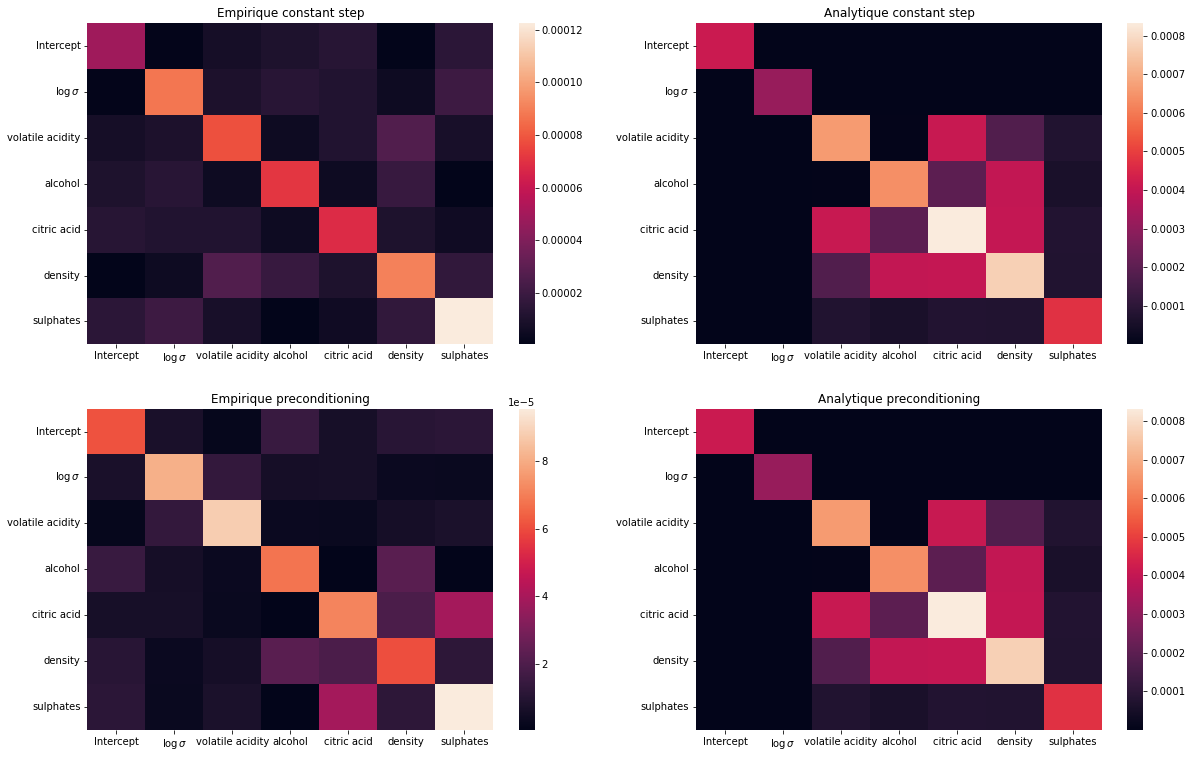

In [64]:
plt.figure(figsize=(20,13))

# On pense bien à calculer la matrice de covariance empirique sur les tirages après convergence de la SGD
labels = ['Intercept', r'$\log \sigma$'] + var
plt.subplot(2,2,1)
sns.heatmap(np.abs(np.cov(theta_sgd_c[cv_it:].T)), xticklabels=labels, yticklabels=labels)
plt.title('Empirique constant step')

plt.subplot(2,2,2)
sns.heatmap(np.abs(Σ_c), xticklabels=labels, yticklabels=labels)
plt.title('Analytique constant step')

plt.subplot(2,2,3)
sns.heatmap(np.abs(np.cov(theta_sgd_pre[cv_it:].T)), xticklabels=labels, yticklabels=labels)
plt.title('Empirique preconditioning')

plt.subplot(2,2,4)
sns.heatmap(np.abs(Σ_pre), xticklabels=labels, yticklabels=labels)
plt.title('Analytique preconditioning')

plt.show()